In [1]:
import os
import yaml
import json
import ultralytics
from ultralytics import YOLO
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import numpy as np
import pandas as pd
import cv2
import utils
import trainer
import evaluator
import data_process
import motion_blur
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# run data_process.py to generate data of the annotated potholes with severity levels
!python3 data_process.py --with_severity_levels True

Data already was processed



In [3]:
input_size = 448

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
    torchvision.transforms.Normalize(mean=data_process.train_mean.tolist(), std=data_process.train_std.tolist())
])


data_path = 'data/annotated_potholes_dataset_with_severity'
train_set, val_set, test_set = data_process.load_data(
    transform=transform,
    input_size=input_size,
    img_dir=os.path.join(data_path, 'images'),
    ann_dir = os.path.join(data_path, 'annotations'),
    with_severity_levels=True
)   

test_set_uni_001 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.01})
test_set_uni_005 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.05})
test_set_uni_01 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.1})
test_set_elli_001 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.01})
test_set_elli_005 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.05})
test_set_elli_01 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.1})
test_set_nat = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'natural', 'kernel_path': './data/motion_blur_data'})

Number of valid images: 714
Train set size: 499 - 69.89%
Validation set size: 72 - 10.08%
Test set size: 143 - 20.03%



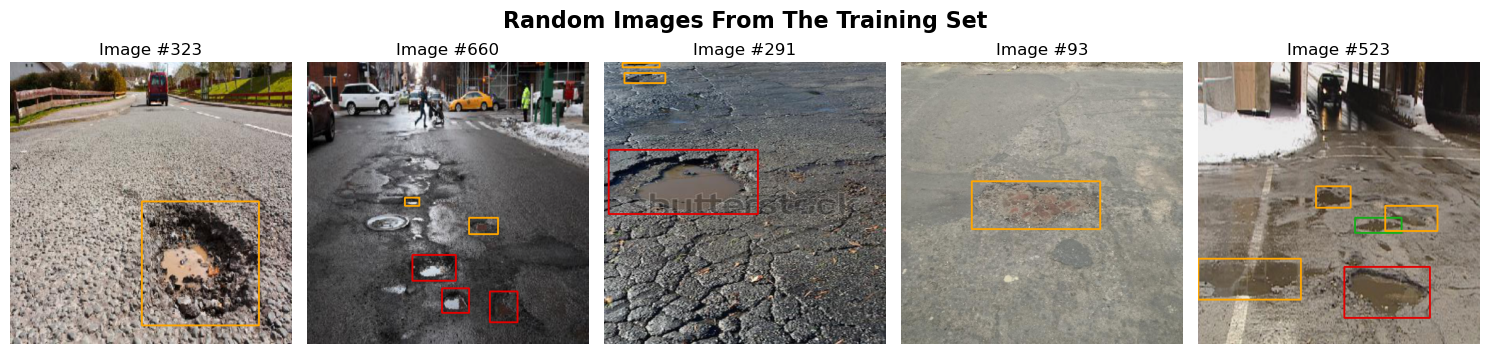

In [5]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=data_process.collate_fn)
images, targets = next(iter(train_loader))
data_process.show_images(images, targets, title="Random Images From The Training Set", with_severity_levels=True)

In [4]:
# Train the fasterrcnn_resenet50_fpn model on the severity levels data **without** augmentation:
history = trainer.train_from_config(model_config_path="./data/models/fasterrcnn_resnet50_fpn/fasterrcnn_resnet50_fpn_best_params.json", train_set=train_set, val_set=val_set, save_path="./data/models/fasterrcnn_resnet_severity", kornia_aug=False, with_severity_levels=True)

Starting training for fasterrcnn_resnet50_fpn with the following parameters:
{'batch_size': 8, 'epochs': 100, 'preweight_mode': 'fine_tuning', 'optimizer': 'SGD', 'lr': 0.005077286891014731, 'momentum': 0.9410626508845523, 'weight_decay': 6.509385638898574e-05, 'scheduler': 'CosineAnnealingLR', 'T_max': 6, 'eta_min': 3.181777359507687e-07}
Epoch 1/100, Train Loss: 35.7142, Val mAP@50: 0.0264, FPS: 54.79, Epoch Time: 23.76 seconds
Epoch 2/100, Train Loss: 25.7683, Val mAP@50: 0.2224, FPS: 54.68, Epoch Time: 23.24 seconds
Epoch 3/100, Train Loss: 20.8433, Val mAP@50: 0.2559, FPS: 55.15, Epoch Time: 23.25 seconds
Epoch 4/100, Train Loss: 17.7709, Val mAP@50: 0.3219, FPS: 54.95, Epoch Time: 23.20 seconds
Epoch 5/100, Train Loss: 15.7690, Val mAP@50: 0.3590, FPS: 55.00, Epoch Time: 23.23 seconds
Epoch 6/100, Train Loss: 13.8952, Val mAP@50: 0.3568, FPS: 55.17, Epoch Time: 23.20 seconds
Epoch 7/100, Train Loss: 13.3938, Val mAP@50: 0.3568, FPS: 55.13, Epoch Time: 23.19 seconds
Epoch 8/100, T

In [5]:
model_name = "fasterrcnn_resnet50_fpn"
model = trainer.get_model(model_name=model_name, with_severity_levels=True) 
state_dict = torch.load("./data/models/fasterrcnn_resnet_severity/fasterrcnn_resnet50_fpn_best.pth", weights_only=True)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# test the model
batch_index = 5
show_batch = False
history['test_map50'] = evaluator.test_model(model, test_set, index=batch_index, title="fasterrcnn_resnet50 - clean test", show_batch=show_batch)
history['uni001_map50'] = evaluator.test_model(model, test_set_uni_001, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.01", show_batch=show_batch)
history['uni005_map50'] = evaluator.test_model(model, test_set_uni_005, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.05", show_batch=show_batch)
history['uni01_map50'] = evaluator.test_model(model, test_set_uni_01, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.1", show_batch=show_batch)
history['eli001_map50'] = evaluator.test_model(model, test_set_elli_001, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.01", show_batch=show_batch)
history['eli005_map50'] = evaluator.test_model(model, test_set_elli_005, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.05", show_batch=show_batch)
history['eli01_map50'] = evaluator.test_model(model, test_set_elli_01, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.1", show_batch=show_batch)
history['nat_map50'] = evaluator.test_model(model, test_set_nat, index=batch_index, title="fasterrcnn_resnet50 - natural noise", show_batch=show_batch)

Mean Average Precision @ 0.5 : 0.3556 FPS: 53.77
Mean Average Precision @ 0.5 : 0.2259 FPS: 53.73
Mean Average Precision @ 0.5 : 0.0956 FPS: 53.96
Mean Average Precision @ 0.5 : 0.0070 FPS: 54.21
Mean Average Precision @ 0.5 : 0.2479 FPS: 53.87
Mean Average Precision @ 0.5 : 0.0781 FPS: 53.96
Mean Average Precision @ 0.5 : 0.0175 FPS: 54.24
Mean Average Precision @ 0.5 : 0.1986 FPS: 54.00


In [6]:
# save history to .json file
utils.update_json(history, model_name="fasterrcnn_resnet_severity")

In [7]:
# Train the fasterrcnn_resenet50_fpn model on the severity levels data with augmentation:
history = trainer.train_from_config(model_config_path="./data/models/fasterrcnn_resnet50_fpn/fasterrcnn_resnet50_fpn_best_params.json", train_set=train_set, val_set=val_set, save_path="./data/models/fasterrcnn_resnet_severity", kornia_aug=True, with_severity_levels=True)

Starting training for fasterrcnn_resnet50_fpn with the following parameters:
{'batch_size': 8, 'epochs': 100, 'preweight_mode': 'fine_tuning', 'optimizer': 'SGD', 'lr': 0.005077286891014731, 'momentum': 0.9410626508845523, 'weight_decay': 6.509385638898574e-05, 'scheduler': 'CosineAnnealingLR', 'T_max': 6, 'eta_min': 3.181777359507687e-07}
Epoch 1/100, Train Loss: 36.2849, Val mAP@50: 0.0000, FPS: 55.04, Epoch Time: 23.50 seconds
Epoch 2/100, Train Loss: 27.6986, Val mAP@50: 0.2343, FPS: 54.78, Epoch Time: 23.53 seconds
Epoch 3/100, Train Loss: 24.2961, Val mAP@50: 0.3185, FPS: 54.83, Epoch Time: 23.61 seconds
Epoch 4/100, Train Loss: 22.1737, Val mAP@50: 0.3636, FPS: 54.90, Epoch Time: 23.66 seconds
Epoch 5/100, Train Loss: 20.6863, Val mAP@50: 0.3405, FPS: 54.88, Epoch Time: 23.59 seconds
Epoch 6/100, Train Loss: 19.0818, Val mAP@50: 0.3738, FPS: 54.83, Epoch Time: 23.52 seconds
Epoch 7/100, Train Loss: 18.9006, Val mAP@50: 0.3738, FPS: 55.02, Epoch Time: 23.56 seconds
Epoch 8/100, T

In [8]:
model_name = "fasterrcnn_resnet50_fpn"
model = trainer.get_model(model_name=model_name, with_severity_levels=True) 
state_dict = torch.load("./data/models/fasterrcnn_resnet_severity/fasterrcnn_resnet50_fpn_aug_best.pth", weights_only=True)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# test the model
batch_index = 5
show_batch = False
history['test_map50'] = evaluator.test_model(model, test_set, index=batch_index, title="fasterrcnn_resnet50 - clean test", show_batch=show_batch)
history['uni001_map50'] = evaluator.test_model(model, test_set_uni_001, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.01", show_batch=show_batch)
history['uni005_map50'] = evaluator.test_model(model, test_set_uni_005, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.05", show_batch=show_batch)
history['uni01_map50'] = evaluator.test_model(model, test_set_uni_01, index=batch_index, title="fasterrcnn_resnet50 - uniform noise - a=0.1", show_batch=show_batch)
history['eli001_map50'] = evaluator.test_model(model, test_set_elli_001, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.01", show_batch=show_batch)
history['eli005_map50'] = evaluator.test_model(model, test_set_elli_005, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.05", show_batch=show_batch)
history['eli01_map50'] = evaluator.test_model(model, test_set_elli_01, index=batch_index, title="fasterrcnn_resnet50 - ellipse noise - a=0.1", show_batch=show_batch)
history['nat_map50'] = evaluator.test_model(model, test_set_nat, index=batch_index, title="fasterrcnn_resnet50 - natural noise", show_batch=show_batch)

Mean Average Precision @ 0.5 : 0.3469 FPS: 53.66
Mean Average Precision @ 0.5 : 0.3429 FPS: 53.81
Mean Average Precision @ 0.5 : 0.3167 FPS: 53.76
Mean Average Precision @ 0.5 : 0.2406 FPS: 53.78
Mean Average Precision @ 0.5 : 0.3677 FPS: 53.59
Mean Average Precision @ 0.5 : 0.2880 FPS: 53.73
Mean Average Precision @ 0.5 : 0.1850 FPS: 53.79
Mean Average Precision @ 0.5 : 0.3370 FPS: 53.87


In [9]:
# save history to .json file
utils.update_json(history, model_name="fasterrcnn_resnet_severity_aug")

In [7]:
yolov8m_dir = './data/models/yolov8m'
dataset_yaml_path = './data/potholes_dataset_with_severity_levels/yolo.yaml' # make sure to execute the data_process.py script first
yolo_params = {
    'image_size' : 640,
    'batch_size' : 8,
    'epochs' : 100
}

In [8]:
# Initialize model
model = YOLO(os.path.join(yolov8m_dir, 'yolov8m.pt'))

# Train the model
results = model.train(
            data=dataset_yaml_path,
            imgsz=yolo_params['image_size'],
            epochs=yolo_params['epochs'],
            batch=yolo_params['batch_size'],
            name=f'yolov8m_severity_train',
            project=os.path.join(yolov8m_dir, 'runs'),
            device=0, 
            patience=0 
        )

New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=./data/models/yolov8m/yolov8m.pt, data=./data/potholes_dataset_with_severity_levels/yolo.yaml, epochs=100, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=./data/models/yolov8m/runs, name=yolov8m_severity_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

100%|██████████| 5.35M/5.35M [00:00<00:00, 8.41MB/s]


AMP: checks passed ✅


train: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train/labels... 498 images, 0 backgrounds, 3 corrupt: 100%|██████████| 498/498 [00:00<00:00, 1861.00it/s]

train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train/images/img_556.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0263      1.0525       1.075]
train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train/images/img_670.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0905      1.1552      1.1552]
train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train/images/img_693.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1295      1.0935]
train: New cache created: /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train/labels.cache



val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/val/labels... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<00:00, 3588.24it/s]

val: New cache created: /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/val/labels.cache


Plotting labels to data/models/yolov8m/runs/yolov8m_severity_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/models/yolov8m/runs/yolov8m_severity_train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.34G      1.611      2.974       1.57         33        640: 100%|██████████| 62/62 [00:06<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         72        179     0.0145      0.545     0.0129    0.00598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.54G      1.577      2.365      1.593         48        640: 100%|██████████| 62/62 [00:05<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179     0.0101      0.186    0.00579    0.00235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.54G      1.667      2.299       1.66         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.37it/s]

                   all         72        179    0.00517      0.043    0.00282    0.00109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.54G      1.648      2.187      1.613         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.39it/s]

                   all         72        179      0.243      0.393      0.208      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.69G      1.621      2.106      1.635         21        640: 100%|██████████| 62/62 [00:05<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]

                   all         72        179      0.266      0.279      0.251      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.54G      1.682      2.151      1.684         28        640: 100%|██████████| 62/62 [00:05<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.94it/s]

                   all         72        179      0.431      0.446      0.376      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.57G      1.581      1.974      1.595         20        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179      0.312      0.437      0.318      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.55G      1.605      1.973      1.583         17        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]

                   all         72        179     0.0779      0.226     0.0188    0.00953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.61G      1.529      1.869      1.534         36        640: 100%|██████████| 62/62 [00:05<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


                   all         72        179      0.379      0.398      0.324       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.56G      1.499      1.869      1.535         28        640: 100%|██████████| 62/62 [00:05<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.04it/s]

                   all         72        179      0.352      0.411      0.339      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.54G      1.488      1.865      1.522         41        640: 100%|██████████| 62/62 [00:05<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]

                   all         72        179      0.467      0.424      0.396      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.55G      1.481      1.801      1.503         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         72        179      0.392      0.449      0.395      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.57G      1.443      1.753      1.497         33        640: 100%|██████████| 62/62 [00:05<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         72        179      0.369      0.438      0.396      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.69G      1.399      1.699      1.444         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.09it/s]

                   all         72        179       0.38      0.502      0.392      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.56G       1.39      1.682      1.451         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.07it/s]

                   all         72        179      0.466       0.48      0.432      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.53G      1.397      1.677       1.45         28        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179      0.371      0.527      0.467      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.57G       1.39      1.615      1.433         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         72        179       0.49      0.444      0.436      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.55G      1.361      1.615      1.414         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]

                   all         72        179      0.585      0.397      0.455       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.56G      1.362      1.618       1.45         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179      0.406      0.486      0.456      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.54G      1.292      1.545      1.378         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         72        179      0.438      0.511      0.432      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.56G      1.341      1.576      1.388         29        640: 100%|██████████| 62/62 [00:05<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.507      0.457      0.472      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.57G      1.304      1.538      1.386         49        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]

                   all         72        179      0.447      0.491      0.468       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.58G       1.34       1.54       1.41         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]

                   all         72        179      0.525      0.469      0.483      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.55G      1.308      1.488      1.385         51        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


                   all         72        179       0.46      0.468      0.466      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.57G      1.274      1.457      1.363         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.10it/s]

                   all         72        179      0.576      0.498      0.502      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.54G      1.291      1.486      1.392         46        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]

                   all         72        179      0.479      0.466      0.453      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.55G      1.268       1.43      1.345         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179      0.463      0.464      0.473      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.53G      1.277      1.475      1.381         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


                   all         72        179      0.434      0.493      0.441      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.57G      1.211      1.419      1.322         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]

                   all         72        179      0.426      0.519      0.474      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.57G      1.191      1.361      1.311         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]

                   all         72        179      0.438      0.492      0.452      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.57G      1.216      1.353      1.312         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179      0.616      0.489      0.539      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.56G      1.207      1.377      1.313         36        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


                   all         72        179      0.496      0.509      0.484      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.57G      1.199      1.309      1.306         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         72        179      0.491      0.517      0.493      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.58G      1.196      1.301      1.298         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         72        179      0.436      0.492      0.437      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.57G      1.139      1.258      1.253         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]

                   all         72        179      0.466      0.522      0.464      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.64G      1.129      1.241      1.273         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.424      0.562      0.475      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.56G      1.162      1.261      1.294         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]

                   all         72        179      0.391      0.572      0.442      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.54G      1.129      1.178      1.256         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


                   all         72        179      0.525      0.471      0.487       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.57G      1.122      1.188      1.264         37        640: 100%|██████████| 62/62 [00:05<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.488      0.576      0.507      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.56G      1.135      1.209      1.276         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179       0.51      0.467      0.481      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.57G      1.101      1.167       1.22         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.436      0.539      0.492      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.56G      1.108      1.202       1.26         29        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]

                   all         72        179      0.444      0.499      0.446      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.54G      1.078      1.125      1.222         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.493      0.497      0.491      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.55G      1.094      1.131      1.236         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179      0.484      0.465      0.483      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.57G      1.064      1.084      1.228         17        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


                   all         72        179      0.476      0.457      0.485      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.53G      1.042      1.077      1.212         53        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.495      0.522      0.497      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.57G      1.039      1.078      1.218         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         72        179      0.548      0.504      0.491      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.54G      1.009      1.045       1.18         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


                   all         72        179       0.52      0.408      0.464      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.59G      1.062      1.102      1.221         48        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.587       0.48      0.509      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.57G       1.01      1.047      1.184         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.621      0.486      0.516      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.56G      1.029      1.031      1.204         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.527      0.505      0.487      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.56G      1.019      1.003      1.193         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]

                   all         72        179      0.423      0.558      0.481      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.58G     0.9823      1.014      1.158         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.486      0.465      0.418      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.56G      1.003     0.9923      1.202         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


                   all         72        179      0.503      0.492      0.468      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.54G     0.9818     0.9989      1.183         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         72        179      0.458      0.542      0.479       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.55G          1      1.009      1.181         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.487      0.478      0.464      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.65G     0.9738     0.9495      1.158         24        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.445      0.554      0.488      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.57G     0.9685     0.9436      1.169         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179      0.476      0.512      0.467      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.54G     0.9515     0.8942       1.15         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


                   all         72        179      0.438      0.549      0.467      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.65G     0.9456     0.8737      1.144         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]

                   all         72        179      0.465      0.478      0.429      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.56G     0.9514     0.8763      1.162         60        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


                   all         72        179      0.534      0.517      0.499      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.55G     0.9321      0.882       1.14         35        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.521      0.551      0.524      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.56G      0.951     0.8828      1.142         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.503      0.525      0.516      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.55G      0.907     0.8484      1.119         20        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


                   all         72        179      0.601      0.416      0.511      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.57G     0.9207     0.8514      1.142         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]

                   all         72        179      0.602      0.422      0.475      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.54G     0.9033     0.8421      1.124         18        640: 100%|██████████| 62/62 [00:05<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


                   all         72        179      0.546      0.449      0.492      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.57G     0.8751     0.8064       1.11         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]

                   all         72        179      0.507      0.501       0.51      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.65G     0.9162      0.835      1.112         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]

                   all         72        179      0.558      0.515       0.54      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.56G     0.8828     0.7898      1.126         16        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.506       0.53       0.48      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.68G     0.8484     0.7584      1.073         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]

                   all         72        179      0.439      0.639      0.509      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.55G     0.8369     0.7366      1.073         46        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]

                   all         72        179      0.602      0.479      0.502      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.54G     0.8342     0.7402      1.089         27        640: 100%|██████████| 62/62 [00:05<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.466      0.554      0.469      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.56G     0.8574     0.7584      1.092         17        640: 100%|██████████| 62/62 [00:05<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.583       0.45      0.475      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.57G     0.8523     0.7351       1.09         42        640: 100%|██████████| 62/62 [00:05<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


                   all         72        179      0.525      0.506      0.477      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.55G     0.8232     0.6861      1.062         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]

                   all         72        179      0.468      0.531       0.46      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.55G     0.8361     0.7074      1.086         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.474       0.57      0.499      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.57G     0.8191     0.6915      1.073         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]

                   all         72        179      0.543      0.532      0.504      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.64G     0.8076     0.7196      1.066         43        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.589      0.406      0.473      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.54G     0.8104     0.6833      1.078         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]

                   all         72        179      0.449      0.553      0.498      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.55G     0.7775     0.6593      1.045         41        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.499      0.503      0.488      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.57G     0.7745     0.6671      1.053         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]

                   all         72        179      0.533      0.497      0.487      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.55G     0.7737     0.6648      1.044         37        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]

                   all         72        179      0.556      0.467      0.463      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.56G     0.7705     0.6628      1.062         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


                   all         72        179       0.52      0.514      0.511      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.56G     0.7646     0.6392      1.049         38        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]

                   all         72        179      0.505      0.471      0.474      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.57G     0.7499     0.6241      1.041         51        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


                   all         72        179      0.492      0.553      0.487      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.57G     0.7551     0.6167      1.043         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


                   all         72        179      0.519      0.516      0.487      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.67G     0.7139     0.5969      1.022         43        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]

                   all         72        179       0.48      0.516      0.479      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.54G     0.7262     0.5915      1.011         19        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.473      0.524      0.492        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.58G     0.7269     0.5906      1.023         41        640: 100%|██████████| 62/62 [00:05<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.475      0.529      0.471      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.56G     0.7286     0.6012      1.032         35        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]

                   all         72        179      0.535      0.508      0.494      0.307


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.54G     0.6611     0.5265     0.9806          9        640: 100%|██████████| 62/62 [00:06<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.489      0.574      0.486      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.57G     0.6249     0.5179     0.9482         15        640: 100%|██████████| 62/62 [00:05<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]

                   all         72        179      0.465      0.539      0.487      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.56G     0.6194     0.4713     0.9468         14        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179      0.514      0.521        0.5      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.57G     0.6111     0.4397     0.9518         14        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.532      0.489      0.494      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.54G     0.6262     0.4732     0.9481         12        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


                   all         72        179      0.475      0.516      0.482      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.53G     0.6031     0.4336     0.9383         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.506      0.504      0.491      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.55G      0.583      0.421      0.932         19        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.542      0.543       0.51      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.56G     0.5817     0.4224     0.9263         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]

                   all         72        179      0.508      0.581      0.512      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.55G     0.5843     0.4116     0.9333         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]

                   all         72        179      0.499      0.559      0.503      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.55G     0.5701     0.4079     0.9247         16        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.545      0.491        0.5      0.311



100 epochs completed in 0.185 hours.
Optimizer stripped from data/models/yolov8m/runs/yolov8m_severity_train/weights/last.pt, 52.0MB
Optimizer stripped from data/models/yolov8m/runs/yolov8m_severity_train/weights/best.pt, 52.0MB

Validating data/models/yolov8m/runs/yolov8m_severity_train/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


                   all         72        179       0.56      0.518       0.54      0.326
         minor_pothole         19         31      0.355      0.302      0.303       0.14
        medium_pothole         51         86      0.606      0.512       0.57       0.34
         major_pothole         42         62       0.72      0.742      0.746      0.497
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_train


In [9]:
# load results.csv from the last run
train_results = pd.read_csv(os.path.join(results.save_dir, 'results.csv'))

# Extract training loss (box loss + obj loss) and convert them to numpy array
train_losses = (train_results['train/box_loss'] + train_results['train/cls_loss'] + train_results['train/dfl_loss']).tolist()
val_maps = train_results['metrics/mAP50(B)'].tolist()

training_time = sum(train_results['time'].tolist())

_ ,model_size = utils.calc_model_size(model)
model_parameters = sum(p.numel() for p in model.parameters())

best_val_map = max(val_maps)

In [11]:
# test the model on the test
model_v8 = YOLO('./data/models/yolov8m/runs/yolov8m_severity_train/weights/best.pt')


test_results = model_v8.val(data=dataset_yaml_path, split='test', name=f'yolov8m_severity_test', project='./data/models/yolov8m/runs/')
test_noisy_uni001_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni001', name=f'yolov8m_severity_test_uniform_001', project='./data/models/yolov8m/runs/')
test_noisy_uni005_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni005', name=f'yolov8m_severity_test_uniform_005', project='./data/models/yolov8m/runs/')
test_noisy_uni01_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni01', name=f'yolov8m_severity_test_uniform_01', project='./data/models/yolov8m/runs/')   
test_noisy_eli001_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli001',  name=f'yolov8m_severity_test_ellipse_001', project='./data/models/yolov8m/runs/')
test_noisy_eli005_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli005', name=f'yolov8m_severity_test_ellipse_005', project='./data/models/yolov8m/runs/')
test_noisy_eli01_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli01', name=f'yolov8m_severity_test_ellipse_01', project='./data/models/yolov8m/runs/')
test_noisy_nat_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_nat', name=f'yolov8m_severity_test_natural', project='./data/models/yolov8m/runs/')

tests_results =  {
                  'test_map50': test_results.box.map50,
                  'uni001_map50': test_noisy_uni001_results.box.map50,
                  'uni005_map50': test_noisy_uni005_results.box.map50,
                  'uni01_map50': test_noisy_uni01_results.box.map50,
                  'eli001_map50': test_noisy_eli001_results.box.map50,
                  'eli005_map50': test_noisy_eli005_results.box.map50,
                  'eli01_map50': test_noisy_eli01_results.box.map50,
                  'nat_map50': test_noisy_nat_results.box.map50,
                 }

print(tests_results)

Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


                   all        143        354      0.449      0.555      0.491      0.329
         minor_pothole         41         82      0.328      0.366      0.254      0.161
        medium_pothole         96        159      0.478      0.598      0.533      0.359
         major_pothole         72        113      0.542      0.702      0.687      0.467
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni001/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


                   all        143        354      0.408      0.526      0.454      0.281
         minor_pothole         41         82      0.309      0.195       0.19     0.0901
        medium_pothole         96        159      0.465      0.648      0.488      0.309
         major_pothole         72        113      0.448      0.735      0.685      0.444
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_001
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni005/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


                   all        143        354      0.307      0.197      0.196       0.11
         minor_pothole         41         82          0          0     0.0038    0.00169
        medium_pothole         96        159      0.343      0.145      0.116     0.0512
         major_pothole         72        113      0.577      0.447      0.468      0.278
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_005
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni01/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


                   all        143        354      0.164     0.0883     0.0791     0.0398
         minor_pothole         41         82     0.0582     0.0122    0.00698    0.00258
        medium_pothole         96        159     0.0813     0.0314     0.0238    0.00854
         major_pothole         72        113      0.353      0.221      0.207      0.108
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_01
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli001/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


                   all        143        354      0.498      0.449      0.475      0.286
         minor_pothole         41         82      0.433      0.195      0.243      0.125
        medium_pothole         96        159      0.524      0.525      0.493      0.286
         major_pothole         72        113      0.537      0.625      0.689      0.447
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_001
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli005/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


                   all        143        354      0.292       0.18      0.192      0.102
         minor_pothole         41         82     0.0425     0.0122     0.0117    0.00431
        medium_pothole         96        159      0.316      0.138      0.143     0.0559
         major_pothole         72        113      0.518      0.391      0.422      0.246
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_005
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli01/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


                   all        143        354      0.174     0.0809     0.0948     0.0445
         minor_pothole         41         82          0          0          0          0
        medium_pothole         96        159     0.0387     0.0126     0.0303     0.0106
         major_pothole         72        113      0.484       0.23      0.254      0.123
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_01
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_nat/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


                   all        143        354      0.404       0.38      0.358      0.217
         minor_pothole         41         82      0.191      0.122     0.0917     0.0458
        medium_pothole         96        159      0.531      0.453      0.411      0.252
         major_pothole         72        113      0.488      0.566      0.571      0.353
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_natural
{'test_map50': 0.49145947276154445, 'uni001_map50': 0.45439066213933493, 'uni005_map50': 0.1959615885319912, 'uni01_map50': 0.07909590267835237, 'eli001_map50': 0.4749744251329921, 'eli005_map50': 0.19203808281102153, 'eli01_map50': 0.09484405435089766, 'nat_map50': 0.3577419164195548}


In [12]:
history = {
    'train_losses': train_losses,
    'val_maps': val_maps,
    'best_val_map': best_val_map,
    'fps': 1 / 5.2e-3, # 5.2 ms per frame from the training logs
    'train_time': training_time,
    'model_parameters': model_parameters,
    'model_size': model_size,
    'test_map50': test_results.box.map50,
    'uni001_map50': test_noisy_uni001_results.box.map50,
    'uni005_map50': test_noisy_uni005_results.box.map50,
    'uni01_map50': test_noisy_uni01_results.box.map50,
    'eli001_map50': test_noisy_eli001_results.box.map50,
    'eli005_map50': test_noisy_eli005_results.box.map50,
    'eli01_map50': test_noisy_eli01_results.box.map50,
    'nat_map50': test_noisy_nat_results.box.map50
}

utils.update_json(history, model_name="yolov8m_severity", save_path='./')

In [13]:
## Train a yolov8m model WITH AUGMENTATION (kornia's motion blur)

# YOLO doesn't have an option to select another dataset other than 'train' so we will have to override the .yaml
# Copy a config snapshot of the original dataset
with open(dataset_yaml_path,'r') as f:
    dataset_config = yaml.safe_load(f)

# Update the snapshot's 'train' accordingly
dataset_config['train'] = dataset_config['train_augmented']

# Save modified snapshot into a new yaml file
augmented_dataset_yaml_path = os.path.join(os.path.dirname(dataset_yaml_path), 'augmented_dataset.yaml')
with open(augmented_dataset_yaml_path, 'w') as f:
    yaml.dump(dataset_config, f)

print(f"Modified dataset YAML saved to: {augmented_dataset_yaml_path}")

Modified dataset YAML saved to: ./data/potholes_dataset_with_severity_levels/augmented_dataset.yaml


In [14]:
yolov8m_dir = './data/models/yolov8m'
dataset_yaml_path = './data/potholes_dataset_with_severity_levels/augmented_dataset.yaml' # make sure to execute the data_process.py script first
yolo_params = {
    'image_size' : 640,
    'batch_size' : 8,
    'epochs' : 100
}

In [15]:
# Initialize model
model = YOLO(os.path.join(yolov8m_dir, 'yolov8m.pt'))

# Train the model
results = model.train(
            data=dataset_yaml_path,
            imgsz=yolo_params['image_size'],
            epochs=yolo_params['epochs'],
            batch=yolo_params['batch_size'],
            name=f'yolov8m_severity_train_aug',
            project=os.path.join(yolov8m_dir, 'runs'),
            device=0, 
            patience=0 
        )

New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=./data/models/yolov8m/yolov8m.pt, data=./data/potholes_dataset_with_severity_levels/augmented_dataset.yaml, epochs=100, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=./data/models/yolov8m/runs, name=yolov8m_severity_train_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fa

train: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train_augmented/labels... 498 images, 0 backgrounds, 3 corrupt: 100%|██████████| 498/498 [00:00<00:00, 1780.24it/s]

train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train_augmented/images/img_556.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0263      1.0525       1.075]
train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train_augmented/images/img_670.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0905      1.1552      1.1552]
train: WARNING ⚠️ /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train_augmented/images/img_693.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1295      1.0935]
train: New cache created: /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/train_augmented/labels.cache



val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/val/labels.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]


Plotting labels to data/models/yolov8m/runs/yolov8m_severity_train_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/models/yolov8m/runs/yolov8m_severity_train_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.38G      1.848      3.159      1.739         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]

                   all         72        179     0.0736      0.198     0.0957     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.65G      1.789      2.632      1.741         48        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]

                   all         72        179    0.00836      0.249    0.00564    0.00279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.67G      1.829      2.522      1.774         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]

                   all         72        179     0.0872       0.45     0.0654      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.67G      1.814      2.351      1.735         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.10it/s]

                   all         72        179      0.189      0.272      0.143     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.81G      1.798      2.354      1.753         21        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.84it/s]

                   all         72        179      0.227      0.322      0.116     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.81G      1.818      2.359       1.74         28        640: 100%|██████████| 62/62 [00:05<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]

                   all         72        179       0.43      0.359      0.311      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.81G      1.744       2.22      1.701         20        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]

                   all         72        179      0.111      0.454      0.174     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.66G      1.803      2.241      1.711         17        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.93it/s]

                   all         72        179      0.365      0.336      0.265      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.8G      1.688      2.133      1.636         36        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]

                   all         72        179      0.273       0.28       0.21      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.82G      1.654       2.11      1.643         28        640: 100%|██████████| 62/62 [00:05<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


                   all         72        179      0.337      0.345      0.324      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.79G      1.703       2.11      1.656         41        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]

                   all         72        179      0.456      0.472      0.429      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.69G      1.619      2.016      1.587         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


                   all         72        179      0.316      0.409      0.334      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.8G      1.636       1.99      1.599         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.11it/s]

                   all         72        179      0.453      0.405      0.364      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.81G       1.62      1.941      1.575         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]

                   all         72        179      0.421      0.403      0.394      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.8G      1.559      1.892      1.544         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.11it/s]

                   all         72        179      0.551      0.455      0.452      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.65G      1.568      1.872      1.539         28        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


                   all         72        179      0.371      0.529      0.436      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.81G      1.581      1.868      1.561         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]

                   all         72        179       0.34      0.478      0.381      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.81G      1.537      1.794      1.516         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.01it/s]

                   all         72        179      0.492      0.472      0.443      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.79G      1.539      1.798      1.561         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]

                   all         72        179       0.44      0.519      0.454      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.78G      1.504      1.764      1.501         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.11it/s]

                   all         72        179       0.41      0.535      0.451      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.81G      1.513      1.792      1.509         29        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


                   all         72        179       0.44      0.484      0.453      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.79G       1.48      1.775      1.499         49        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]

                   all         72        179      0.487      0.397        0.4      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.84G      1.463      1.715       1.48         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.601      0.404      0.474      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.81G       1.46        1.7      1.478         51        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179       0.57      0.414      0.469      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.81G      1.456      1.699      1.474         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]

                   all         72        179      0.502      0.474       0.48      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.81G      1.493      1.687      1.505         46        640: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


                   all         72        179      0.409      0.528      0.425      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.68G      1.445      1.621      1.452         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179      0.412      0.498      0.462      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.81G       1.42      1.635      1.462         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


                   all         72        179      0.493      0.479      0.445      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.81G       1.39      1.589       1.43         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]

                   all         72        179      0.488      0.477       0.45      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.81G      1.375      1.545      1.415         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]

                   all         72        179      0.462      0.518      0.459      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.81G      1.414      1.543      1.433         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.626       0.42      0.475      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.8G       1.38      1.533      1.428         36        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.446      0.509      0.474      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.82G      1.393      1.499      1.436         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


                   all         72        179       0.45      0.607      0.474      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.81G      1.353      1.463      1.394         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179       0.54       0.46      0.473       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.8G      1.279      1.383      1.336         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]

                   all         72        179      0.382      0.573      0.441      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.8G      1.317      1.409      1.387         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.382      0.515      0.446      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.82G      1.355       1.47      1.395         30        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]

                   all         72        179      0.429      0.512      0.457      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       3.8G      1.303      1.388      1.348         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]

                   all         72        179      0.376      0.609      0.487      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.68G      1.284       1.36      1.356         37        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]

                   all         72        179      0.719      0.392      0.518        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.66G      1.306      1.376      1.368         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]

                   all         72        179      0.473      0.508      0.469       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.82G      1.253       1.31      1.308         31        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]

                   all         72        179      0.516      0.469      0.488      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.81G      1.244      1.307      1.336         29        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.472       0.45      0.437      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.68G      1.219       1.31      1.299         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.555      0.442      0.484      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.79G      1.276      1.317      1.356         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]

                   all         72        179      0.484      0.572      0.514      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.8G      1.226      1.259       1.32         17        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


                   all         72        179      0.513      0.454      0.473      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.82G      1.206      1.265      1.322         53        640: 100%|██████████| 62/62 [00:05<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


                   all         72        179      0.531       0.48      0.505      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.82G       1.21      1.286      1.326         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.462        0.5       0.44      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.78G      1.157      1.222       1.27         34        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


                   all         72        179      0.532      0.379      0.428      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.83G       1.18      1.262      1.294         48        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.489      0.475       0.47      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.81G      1.147       1.19       1.27         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.414      0.441       0.42       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       3.8G      1.149      1.174      1.267         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


                   all         72        179      0.487      0.523      0.511      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.79G      1.153      1.172       1.26         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179      0.569      0.475      0.512      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.81G      1.123      1.135      1.235         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


                   all         72        179       0.49      0.478      0.476      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.8G      1.179      1.149      1.298         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


                   all         72        179      0.451      0.533      0.479      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.8G      1.095      1.113      1.249         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


                   all         72        179      0.513        0.5      0.491      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.8G      1.098      1.135      1.221         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179       0.58      0.438      0.478      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.8G      1.104      1.101      1.234         24        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.544      0.458      0.489      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.81G      1.084      1.071      1.237         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.559      0.453      0.496       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.81G      1.036       1.01      1.216         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

                   all         72        179      0.459      0.511      0.467      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.8G      1.064      1.034      1.213         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.486      0.558      0.483      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.79G      1.048      1.019      1.209         60        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]


                   all         72        179       0.46      0.535      0.479       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.79G      1.045      1.012      1.206         35        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


                   all         72        179      0.501      0.566      0.508      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       3.8G      1.051      0.954      1.197         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


                   all         72        179        0.5      0.551      0.509      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.66G      1.022     0.9616       1.18         20        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


                   all         72        179       0.55       0.45      0.493      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.81G      1.032     0.9798      1.196         47        640: 100%|██████████| 62/62 [00:05<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


                   all         72        179      0.468      0.517      0.481      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.67G      1.024     0.9357       1.18         18        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]


                   all         72        179      0.512      0.492      0.503      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.81G      1.005     0.9274      1.187         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


                   all         72        179      0.562      0.516      0.531      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.9G      1.019      0.907      1.184         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


                   all         72        179      0.568      0.451       0.52      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.81G      0.984     0.8909      1.176         16        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179      0.569      0.444      0.507      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.8G     0.9899     0.8964      1.161         23        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.537      0.499      0.489      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.8G     0.9532     0.8538      1.146         46        640: 100%|██████████| 62/62 [00:05<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.557      0.487      0.488      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.78G     0.9459     0.8267      1.152         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.515      0.512      0.531      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.82G     0.9546     0.8574      1.146         17        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]

                   all         72        179      0.492      0.472      0.478      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.79G     0.9291     0.8591      1.138         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


                   all         72        179      0.601      0.451      0.493      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.8G     0.9222     0.7903      1.118         44        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


                   all         72        179      0.497        0.5       0.49      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.8G     0.9282     0.8028      1.129         33        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


                   all         72        179      0.598      0.432      0.505        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.81G     0.9037     0.7842      1.127         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179      0.504      0.579      0.528      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.81G     0.8894     0.7789      1.114         43        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]

                   all         72        179      0.594       0.47       0.52      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.67G     0.9034     0.7892      1.123         25        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


                   all         72        179      0.551      0.514      0.531      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       3.8G     0.8711     0.7253      1.108         41        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


                   all         72        179      0.543      0.519      0.527      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.82G     0.8822     0.7499      1.111         42        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]

                   all         72        179      0.631      0.469      0.502      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.8G     0.8758     0.7619      1.106         37        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]

                   all         72        179      0.458      0.533       0.48      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.81G     0.8603     0.7353      1.114         26        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.456      0.512      0.468      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.8G     0.8618     0.7088      1.097         38        640: 100%|██████████| 62/62 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


                   all         72        179      0.512      0.497      0.483      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.81G     0.8581     0.7208        1.1         51        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.528      0.512        0.5      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       3.8G     0.8352     0.6941      1.086         32        640: 100%|██████████| 62/62 [00:05<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.517       0.53      0.501      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.68G     0.8115     0.6881      1.068         43        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]

                   all         72        179      0.528      0.506      0.508      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.78G      0.813     0.6719      1.055         19        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.549      0.512      0.498      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.81G     0.8219     0.6729      1.066         41        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]

                   all         72        179       0.55      0.531      0.511      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.81G     0.8199     0.6774      1.079         35        640: 100%|██████████| 62/62 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


                   all         72        179      0.597      0.463      0.524      0.302
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.66G     0.7917     0.6494      1.052          9        640: 100%|██████████| 62/62 [00:05<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


                   all         72        179      0.552      0.523      0.512      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.81G     0.7427     0.5832      1.013         15        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]


                   all         72        179      0.601      0.469      0.507      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.82G     0.7322      0.554      1.015         14        640: 100%|██████████| 62/62 [00:05<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.40it/s]

                   all         72        179      0.518      0.498      0.485      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.81G     0.6918      0.518     0.9988         14        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]

                   all         72        179      0.549      0.513      0.498      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.79G     0.7127     0.5455     0.9992         12        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


                   all         72        179      0.527      0.516      0.504      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.65G     0.6958     0.5234     0.9961         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]

                   all         72        179      0.594      0.475       0.49      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.79G     0.6654     0.4945     0.9761         19        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]

                   all         72        179      0.587      0.496      0.503      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.79G     0.6637     0.4838     0.9768         22        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]

                   all         72        179       0.56       0.51      0.509      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.8G     0.6711     0.4794     0.9842         27        640: 100%|██████████| 62/62 [00:05<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]

                   all         72        179      0.515      0.539      0.501      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.66G     0.6489     0.4783      0.968         16        640: 100%|██████████| 62/62 [00:05<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


                   all         72        179      0.541      0.545      0.506      0.295

100 epochs completed in 0.185 hours.
Optimizer stripped from data/models/yolov8m/runs/yolov8m_severity_train_aug/weights/last.pt, 52.0MB
Optimizer stripped from data/models/yolov8m/runs/yolov8m_severity_train_aug/weights/best.pt, 52.0MB

Validating data/models/yolov8m/runs/yolov8m_severity_train_aug/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


                   all         72        179      0.473       0.54       0.53      0.315
         minor_pothole         19         31      0.296      0.419      0.356      0.165
        medium_pothole         51         86      0.553      0.523       0.53      0.318
         major_pothole         42         62      0.569      0.677      0.705      0.462
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_train_aug


In [16]:
# load results.csv from the last run
train_results = pd.read_csv(os.path.join(results.save_dir, 'results.csv'))

# Extract training loss (box loss + obj loss) and convert them to numpy array
train_losses = (train_results['train/box_loss'] + train_results['train/cls_loss'] + train_results['train/dfl_loss']).tolist()
val_maps = train_results['metrics/mAP50(B)'].tolist()

training_time = sum(train_results['time'].tolist())

_ ,model_size = utils.calc_model_size(model)
model_parameters = sum(p.numel() for p in model.parameters())

best_val_map = max(val_maps)

In [17]:
# test the model on the test
model_v8 = YOLO('./data/models/yolov8m/runs/yolov8m_severity_train_aug/weights/best.pt')

test_results = model_v8.val(data=dataset_yaml_path, split='test', name=f'yolov8m_severity_test_aug', project='./data/models/yolov8m/runs/')
test_noisy_uni001_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni001', name=f'yolov8m_severity_test_uniform_001_aug', project='./data/models/yolov8m/runs/')
test_noisy_uni005_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni005', name=f'yolov8m_severity_test_uniform_005_aug', project='./data/models/yolov8m/runs/')
test_noisy_uni01_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_uni01', name=f'yolov8m_severity_test_uniform_01_aug', project='./data/models/yolov8m/runs/')   
test_noisy_eli001_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli001',  name=f'yolov8m_severity_test_ellipse_001_aug', project='./data/models/yolov8m/runs/')
test_noisy_eli005_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli005', name=f'yolov8m_severity_test_ellipse_005_aug', project='./data/models/yolov8m/runs/')
test_noisy_eli01_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_eli01', name=f'yolov8m_severity_test_ellipse_01_aug', project='./data/models/yolov8m/runs/')
test_noisy_nat_results = model_v8.val(data=dataset_yaml_path, split='noisy_test_nat', name=f'yolov8m_severity_test_natural_aug', project='./data/models/yolov8m/runs/')

tests_results =  {
                  'test_map50': test_results.box.map50,
                  'uni001_map50': test_noisy_uni001_results.box.map50,
                  'uni005_map50': test_noisy_uni005_results.box.map50,
                  'uni01_map50': test_noisy_uni01_results.box.map50,
                  'eli001_map50': test_noisy_eli001_results.box.map50,
                  'eli005_map50': test_noisy_eli005_results.box.map50,
                  'eli01_map50': test_noisy_eli01_results.box.map50,
                  'nat_map50': test_noisy_nat_results.box.map50,
                 }

print(tests_results)

Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


                   all        143        354      0.487      0.521      0.488      0.323
         minor_pothole         41         82      0.332      0.317       0.26      0.156
        medium_pothole         96        159       0.54      0.539      0.507      0.337
         major_pothole         72        113      0.587      0.708      0.697      0.475
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni001/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


                   all        143        354      0.551      0.436       0.46      0.291
         minor_pothole         41         82      0.353      0.122      0.163     0.0983
        medium_pothole         96        159       0.62      0.503       0.51      0.312
         major_pothole         72        113       0.68      0.681      0.707      0.462
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_001_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni005/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


                   all        143        354      0.453      0.356      0.349      0.197
         minor_pothole         41         82      0.251     0.0732     0.0478     0.0227
        medium_pothole         96        159      0.494      0.428      0.384        0.2
         major_pothole         72        113      0.615      0.566      0.614      0.369
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_005_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_uni01/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


                   all        143        354      0.366      0.258      0.256      0.123
         minor_pothole         41         82     0.0938     0.0244     0.0191    0.00763
        medium_pothole         96        159      0.463      0.319      0.287      0.119
         major_pothole         72        113      0.542       0.43      0.462      0.242
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_uniform_01_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli001/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


                   all        143        354      0.437      0.492       0.44      0.278
         minor_pothole         41         82      0.273      0.234      0.167      0.097
        medium_pothole         96        159      0.491      0.579      0.484      0.301
         major_pothole         72        113      0.546      0.664      0.668      0.437
Speed: 0.1ms preprocess, 5.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_001_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli005/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


                   all        143        354      0.523       0.31      0.318      0.159
         minor_pothole         41         82      0.421     0.0732     0.0713     0.0225
        medium_pothole         96        159      0.511      0.333      0.312      0.142
         major_pothole         72        113      0.635      0.523      0.571      0.312
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_005_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_eli01/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


                   all        143        354      0.303      0.272      0.218     0.0926
         minor_pothole         41         82      0.125      0.061      0.051     0.0216
        medium_pothole         96        159      0.326      0.296      0.184     0.0616
         major_pothole         72        113       0.46       0.46      0.418      0.195
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_ellipse_01_aug
Ultralytics 8.3.59 🚀 Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)


val: Scanning /home/user_138/046211-Deep-Learning/data/potholes_dataset_with_severity_levels/test_nat/labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]


                   all        143        354      0.461      0.387      0.369      0.224
         minor_pothole         41         82      0.272      0.123      0.121      0.068
        medium_pothole         96        159      0.558      0.491      0.431      0.252
         major_pothole         72        113      0.554      0.549      0.556      0.351
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to data/models/yolov8m/runs/yolov8m_severity_test_natural_aug
{'test_map50': 0.48794998412046403, 'uni001_map50': 0.4599632466303025, 'uni005_map50': 0.34872071753795025, 'uni01_map50': 0.2562871845605504, 'eli001_map50': 0.4396249882441028, 'eli005_map50': 0.3182610092535399, 'eli01_map50': 0.21761584134545917, 'nat_map50': 0.3693728502345901}


In [18]:
history = {
    'train_losses': train_losses,
    'val_maps': val_maps,
    'best_val_map': best_val_map,
    'fps': 1 / 5.2e-3, # 5.2 ms per frame from the training logs
    'train_time': training_time,
    'model_parameters': model_parameters,
    'model_size': model_size,
    'test_map50': test_results.box.map50,
    'uni001_map50': test_noisy_uni001_results.box.map50,
    'uni005_map50': test_noisy_uni005_results.box.map50,
    'uni01_map50': test_noisy_uni01_results.box.map50,
    'eli001_map50': test_noisy_eli001_results.box.map50,
    'eli005_map50': test_noisy_eli005_results.box.map50,
    'eli01_map50': test_noisy_eli01_results.box.map50,
    'nat_map50': test_noisy_nat_results.box.map50
}

utils.update_json(history, model_name="yolov8m_severity_aug", save_path='./')